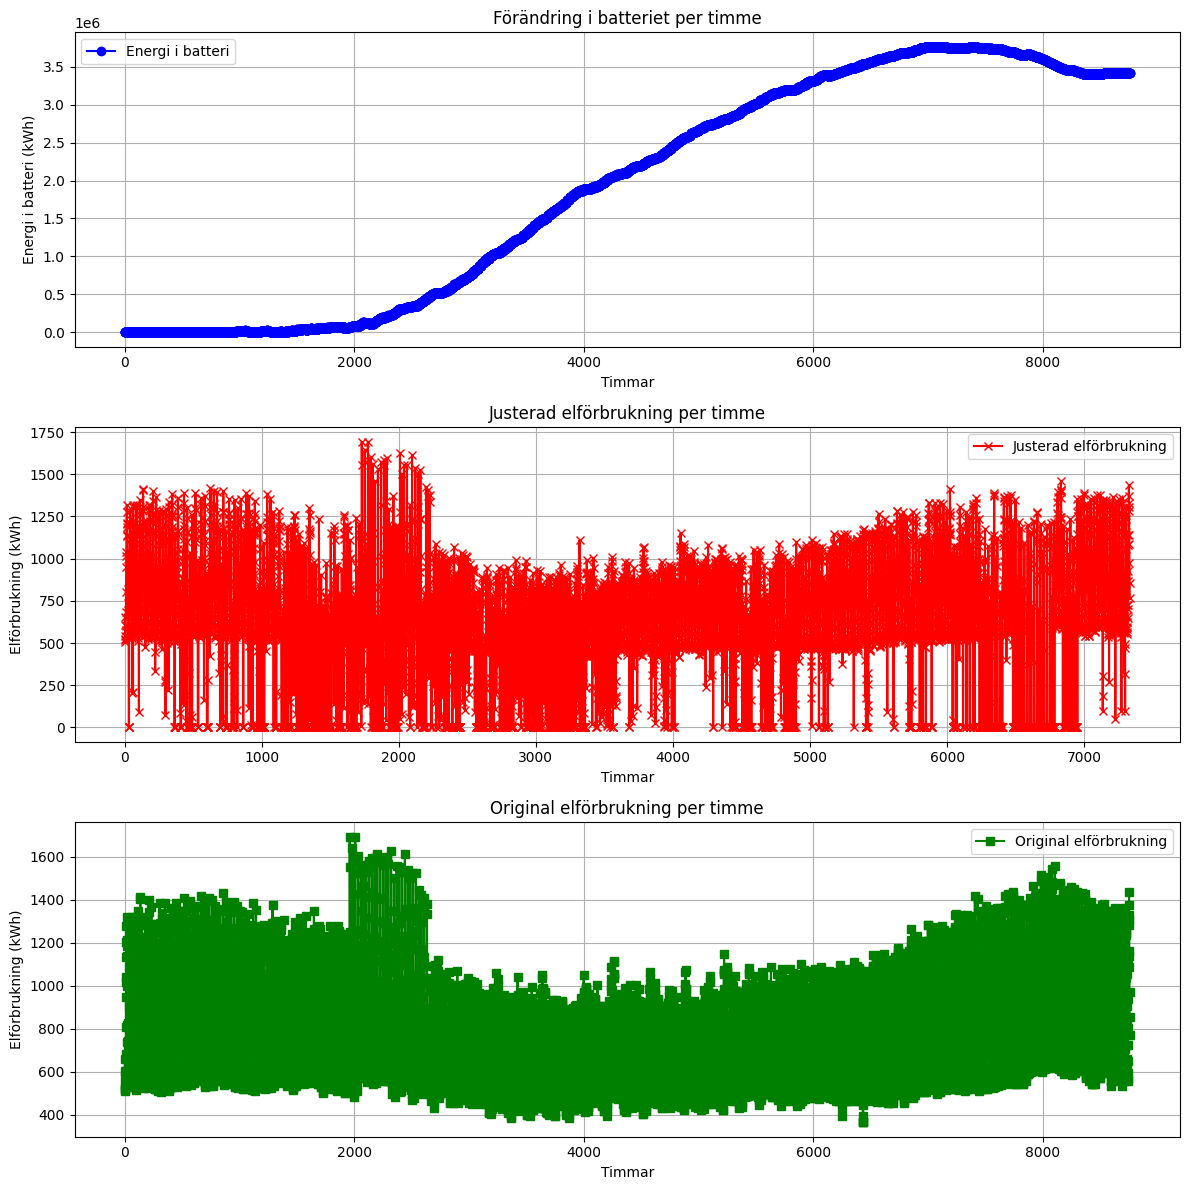

Summa Spotpris 2023: 5689306.300100008
Summa spotpris köpt el med batteri:  [2557727.68474499]
Besparingar(i kr)m.h.a sol och batteri: [3131578.61535502]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx")

# Extract first columns from each
Sol = Solprod.iloc[:, 0]  # First column of Solprod
ABK = ABKEl.iloc[:, 0]    # First column of ABKEl
Spot = Spotpris.iloc[:, 0]    # First column of Spotpris

# Initialize Batteri
batteriKapacitet = 0.0
KöptElSpotpris = 0.0
SummaSpotpris2023 = 0.0

for i in range(len(Spot)):
    SummaSpotpris2023 += Spot[i]*ABK[i]

SummaSpotpris2023 = SummaSpotpris2023/100


# List to store battery and elförbrukning for plotting
elförbrukning = []
battery_values = []
original_consumption = ABK.tolist()

# Iterate through the columns
for i in range(len(Sol)):
    diff = ABK[i] - Sol[i]

    # Update Batteri based on the conditions
    if  Spot[i] <= 35 and Sol[i] > 0: #Lagra solel om spotpris är lägre än 35 öre/kWh
        batteriKapacitet += Sol[i]
        KöptElSpotpris += (Spot[i]*ABK[i]) #Spotpris per kWh el läggs till i summa
        elförbrukning.append(ABK[i])
    elif Spot[i] > 35 and Sol[i] > 0 and diff > 0:
        KöptElSpotpris += [Spot[i]*diff] #Differensen el köps i spotpris och läggs till i summa
        elförbrukning.append(diff)
    elif Spot[i] > 35 and Sol[i] > 0 and diff < 0: #Om spotpris är större än 35 öre och solel finns och är större än elförbrukning
        batteriKapacitet += (-1*diff) #Lagra solelöverskottet
    elif Sol[i] == 0 and batteriKapacitet > 0 and Spot[i] >= 100: #Om ingen solel och spotpriset är högre än 100 öre och batteriel finns
        energiFrånBatteri = min(batteriKapacitet, ABK[i]) #Tar lägsta värdet mellan elförbr. för timmen och energisumman i batteriet, säkerställer att batteriet aldrig blir negativt
        batteriKapacitet -= energiFrånBatteri #Subtraherar energi från batteriet
        KöptElSpotpris += (ABK[i] - energiFrånBatteri)*Spot[i] #Köper restelen (Om elförbrukningen blir minsta köps alltså ingen, ABK[i]-ABK[i])
        elförbrukning.append(ABK[i]- energiFrånBatteri)
    else: 
        KöptElSpotpris += (ABK[i]*Spot[i]) #I alla andra fall köps elen till spotpris
        elförbrukning.append(ABK[i])


 # Store the updated Batteri value for plotting
    battery_values.append(batteriKapacitet)


# Create subplots to display three graphs
fig, ax = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

# Plot Battery Energy
ax[0].plot(range(len(battery_values)), battery_values, label='Energi i batteri', color='blue', marker='o')
ax[0].set_xlabel('Timmar')
ax[0].set_ylabel('Energi i batteri (kWh)')
ax[0].set_title('Förändring i batteriet per timme')
ax[0].legend()
ax[0].grid(True)

# Plot Adjusted Electricity Consumption
ax[1].plot(range(len(elförbrukning)), elförbrukning, label='Justerad elförbrukning', color='red', marker='x')
ax[1].set_xlabel('Timmar')
ax[1].set_ylabel('Elförbrukning (kWh)')
ax[1].set_title('Justerad elförbrukning per timme')
ax[1].legend()
ax[1].grid(True)

# Plot Original Electricity Consumption (ABK)
ax[2].plot(range(len(original_consumption)), original_consumption, label='Original elförbrukning', color='green', marker='s')
ax[2].set_xlabel('Timmar')
ax[2].set_ylabel('Elförbrukning (kWh)')
ax[2].set_title('Original elförbrukning per timme')
ax[2].legend()
ax[2].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

köptEliKr = KöptElSpotpris/100
# Printar summan spotpris och jämför med originalpriset
print("Summa Spotpris 2023:", SummaSpotpris2023)
print("Summa spotpris köpt el med batteri: ", köptEliKr)
print("Besparingar i spotpris(i kr)m.h.a sol och batteri:", SummaSpotpris2023 - köptEliKr)


--- År 1 Slut ---
Batterienergi kvar vid årets slut: 0.0 kWh
Summa spotpris köpt el med batteri år 1: 3228618.5389920007
Besparingar i spotpris år 1: 2460687.7611080073

--- År 2 Slut ---
Batterienergi kvar vid årets slut: 0.0 kWh
Summa spotpris köpt el med batteri år 2: 3228618.5389920007
Besparingar i spotpris år 2: 2460687.7611080073


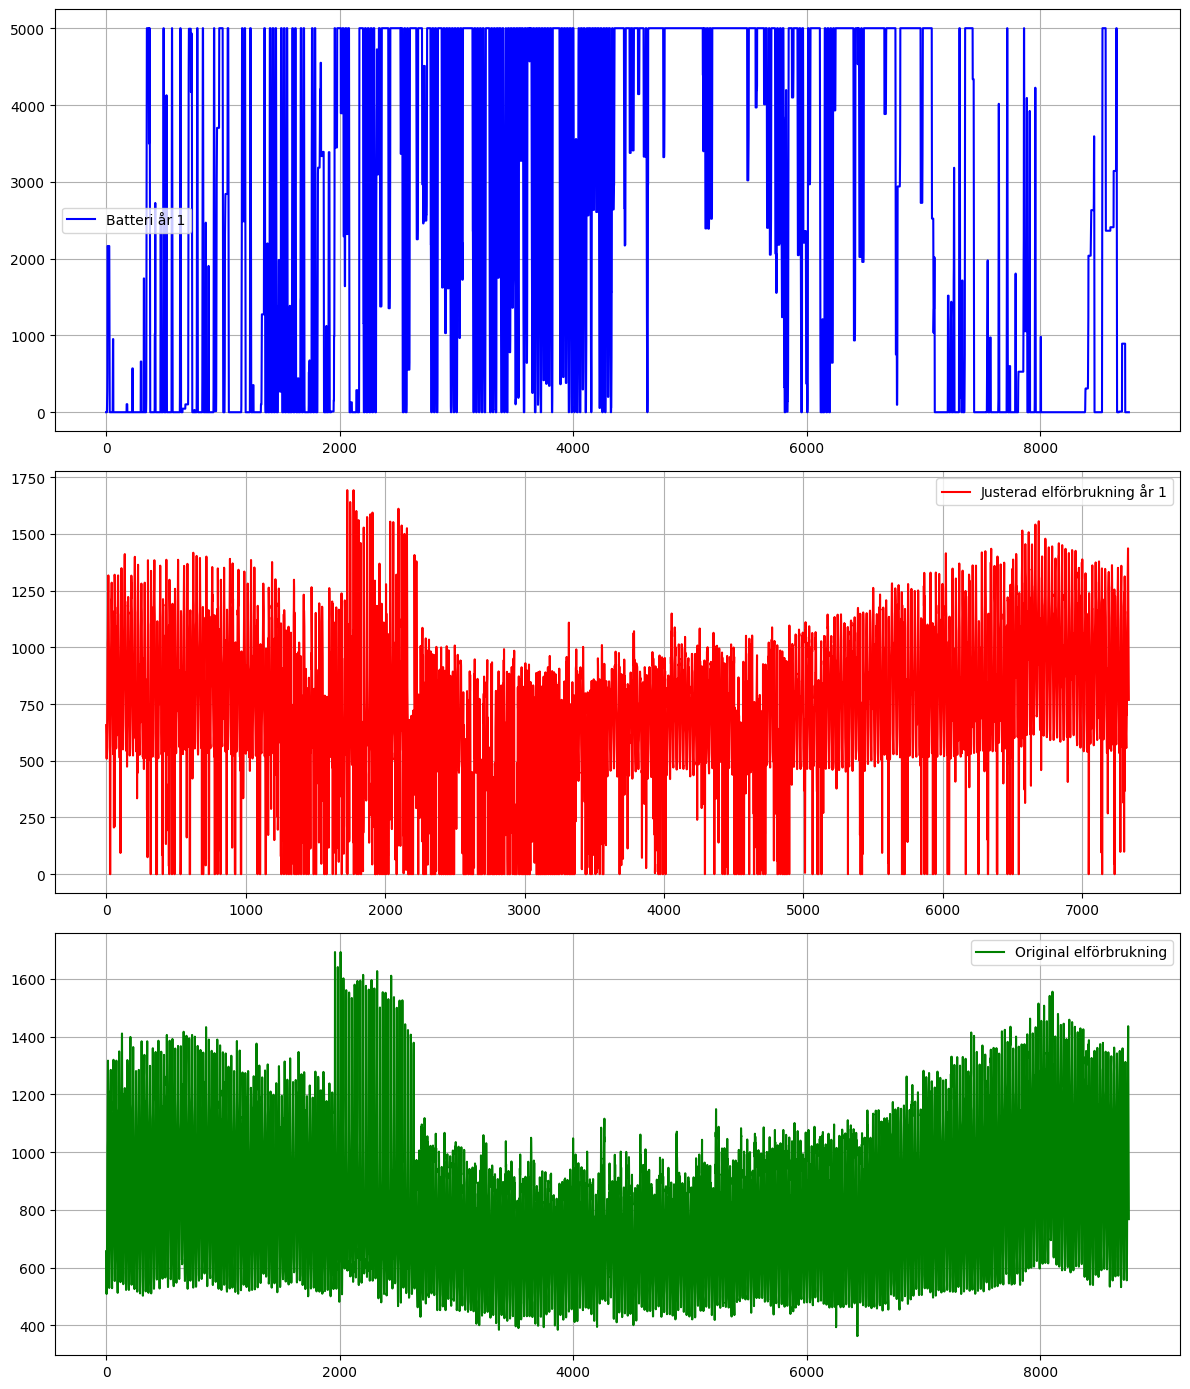

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx")

# Extract first columns from each
Sol = Solprod.iloc[:, 0]  # Solar production
ABK = ABKEl.iloc[:, 0]    # Electricity consumption
Spot = Spotpris.iloc[:, 0]  # Spot price

# Initialize Battery and Costs
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
KöptElSpotpris = 0.0
SummaSpotpris2023 = sum(Spot[i] * ABK[i] for i in range(len(Spot))) / 100  # Total spot price without battery

# Lists to store values for plotting
elförbrukning = []  # Adjusted electricity consumption
battery_values = []  # Battery energy over time
original_consumption = ABK.tolist()  # Convert ABK to list for original consumption

# ----------------------- YEAR 1 SIMULATION -----------------------
KöptElSpotpris = 0.0  # Reset cost for Year 1
for i in range(len(Sol)):
    diff = ABK[i] - Sol[i]

    # Battery and Electricity Purchase Logic
    if Spot[i] <= 35 and Sol[i] > 0:  
        batteriKapacitet = min(batteriKapacitet + Sol[i], batteriMaxKapacitet)
        KöptElSpotpris += Spot[i] * ABK[i]
        elförbrukning.append(ABK[i])
    elif Spot[i] > 35 and Sol[i] > 0 and diff > 0:
        KöptElSpotpris += Spot[i] * diff  
        elförbrukning.append(diff)
    elif Spot[i] > 35 and Sol[i] > 0 and diff < 0:  
        batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  
    elif Sol[i] == 0 and batteriKapacitet > 0 and Spot[i] >= 70:  
        energiFrånBatteri = min(batteriKapacitet, ABK[i])  
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (ABK[i] - energiFrånBatteri) * Spot[i]  
        elförbrukning.append(ABK[i] - energiFrånBatteri)
    else:
        KöptElSpotpris += ABK[i] * Spot[i]  
        elförbrukning.append(ABK[i])

    # Store battery values
    battery_values.append(batteriKapacitet)

# Store battery energy left after year 1
battery_energy_end_of_year1 = batteriKapacitet
köptEliKr_år1 = KöptElSpotpris / 100
besparingar_år1 = SummaSpotpris2023 - köptEliKr_år1

print("\n--- År 1 Slut ---")
print("Batterienergi kvar vid årets slut:", battery_energy_end_of_year1, "kWh")
print("Summa spotpris köpt el med batteri år 1:", köptEliKr_år1)
print("Besparingar i spotpris år 1:", besparingar_år1)

# ----------------------- YEAR 2 SIMULATION -----------------------
batteriKapacitet = battery_energy_end_of_year1  # Start Year 2 with leftover battery energy
KöptElSpotpris = 0.0  # Reset for Year 2
elförbrukning_year2 = []
battery_values_year2 = []

for i in range(len(Sol)):  
    diff = ABK[i] - Sol[i]

    # Battery and Electricity Purchase Logic
    if Spot[i] <= 35 and Sol[i] > 0:  
        batteriKapacitet = min(batteriKapacitet + Sol[i], batteriMaxKapacitet)
        KöptElSpotpris += Spot[i] * ABK[i]  
        elförbrukning_year2.append(ABK[i])
    elif Spot[i] > 35 and Sol[i] > 0 and diff > 0:
        KöptElSpotpris += Spot[i] * diff  
        elförbrukning_year2.append(diff)
    elif Spot[i] > 35 and Sol[i] > 0 and diff < 0:  
        batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  
    elif Sol[i] == 0 and batteriKapacitet > 0 and Spot[i] >= 70:  
        energiFrånBatteri = min(batteriKapacitet, ABK[i])  
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (ABK[i] - energiFrånBatteri) * Spot[i]  
        elförbrukning_year2.append(ABK[i] - energiFrånBatteri)
    else:
        KöptElSpotpris += ABK[i] * Spot[i]  
        elförbrukning_year2.append(ABK[i])

    # Store battery values
    battery_values_year2.append(batteriKapacitet)

köptEliKr_år2 = KöptElSpotpris / 100
besparingar_år2 = SummaSpotpris2023 - köptEliKr_år2

print("\n--- År 2 Slut ---")
print("Batterienergi kvar vid årets slut:", batteriKapacitet, "kWh")
print("Summa spotpris köpt el med batteri år 2:", köptEliKr_år2)
print("Besparingar i spotpris år 2:", besparingar_år2)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 14))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[0].plot(battery_values_year2, label='Batteri år 2', color='cyan', linestyle='dashed')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[1].plot(elförbrukning_year2, label='Justerad elförbrukning år 2', color='orange', linestyle='dashed')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()
